# Data Inspection- Preprocessing - Unsupervised ML

This tutorial demonstrates the most important basic steps involved in the analysis of scanning electron diffraction data.

The data was acquired from a GaAs nanowire adopting the zinc blende structure and exhibiting type I twinning (i.e. on {111}) along its length. The region of interest contains a single nanowire comprising multiple crystals each in one of the two twinned orientations and near to a <1-10> zone axis.

This functionaility has been checked to run in pyxem version 0.13.1 (April 2021). However, bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

1. <a href='#loa'> Loading & Inspection</a>
2. <a href='#cal'> Alignment & Calibration</a>
3. <a href='#vdf'> Virtual Diffraction Imaging</a>
4. <a href='#ml'> Machine Learning SPED Data</a>
5. <a href='#vec'> Peak Finding</a>

Import pyxem and other required libraries

In [1]:
# Changing the matplotlib background will give you interactive 
#%matplotlib qt5

In [2]:
%matplotlib inline
import hyperspy.api as hs
import pyxem as pxm
import numpy as np

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


<a id='loa'></a>

##  1. Loading and Inspection

Load the SPED data acquired from the nanowire

In [3]:
dp = hs.load('./data/01/twinned_nanowire.hdf5')

Inspect the dp object

In [4]:
dp

<Diffraction2D, title: , dimensions: (30, 100|144, 144)>

Specify that the data is electron diffraction data

In [5]:
dp.set_signal_type('electron_diffraction')

Inspect the signal type

In [6]:
dp

<ElectronDiffraction2D, title: , dimensions: (30, 100|144, 144)>

Inspect the data type of the object

In [7]:
dp.data.dtype

dtype('uint8')

Inspect the metadata associated with the object 'dp'

In [8]:
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── beam_energy = 300.0
│       ├── camera_length = 0.21000000000000002
│       └── scan_rotation = 277.0
├── General
│   ├── original_filename = nanowire_precession.blo
│   ├── time = (2014, 12, 8)
│   └── title = 
└── Signal
    ├── binned = False
    ├── signal_origin = 
    └── signal_type = electron_diffraction

Set important experimental parameters using the built in function

In [9]:
dp.set_experimental_parameters(beam_energy=300.0,
                               camera_length=21.0,
                               scan_rotation=277.0,
                               convergence_angle=0.7,
                               exposure_time=10.0)

See how this changed the metadata

In [10]:
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 21.0
│       │       └── exposure_time = 10.0
│       ├── beam_energy = 300.0
│       ├── camera_length = 0.21000000000000002
│       ├── convergence_angle = 0.7
│       └── scan_rotation = 277.0
├── General
│   ├── original_filename = nanowire_precession.blo
│   ├── time = (2014, 12, 8)
│   └── title = 
└── Signal
    ├── binned = False
    ├── signal_origin = 
    └── signal_type = electron_diffraction

Set another metadata item and check it

In [11]:
dp.metadata.set_item("General.title", 'GaAs Nanowire')
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 21.0
│       │       └── exposure_time = 10.0
│       ├── beam_energy = 300.0
│       ├── camera_length = 0.21000000000000002
│       ├── convergence_angle = 0.7
│       └── scan_rotation = 277.0
├── General
│   ├── original_filename = nanowire_precession.blo
│   ├── time = (2014, 12, 8)
│   └── title = GaAs Nanowire
└── Signal
    ├── binned = False
    ├── signal_origin = 
    └── signal_type = electron_diffraction

In [12]:
dp

<ElectronDiffraction2D, title: GaAs Nanowire, dimensions: (30, 100|144, 144)>

Plot the data to inspect it

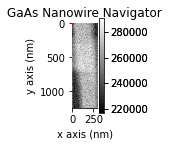

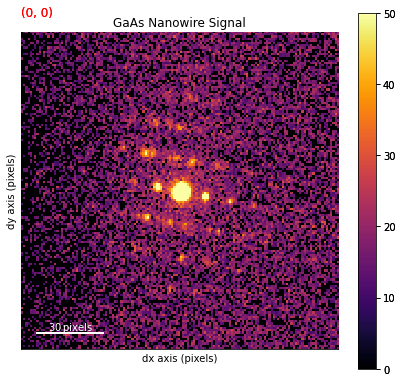

In [13]:
dp.plot(cmap='inferno', vmax=50)

<a id='cal'></a>

## 2. Alignment & Calibration

Apply distortion corrections to the data due to off-axis acquisition

In [14]:
dp.apply_affine_transformation(np.array([[0.99,0,0],
                                         [0,0.69,0],
                                         [0,0,1]]),
                               keep_dtype=True)

In [15]:
dp.data.dtype

dtype('uint8')

Align the dataset based on the direct beam position

In [16]:
dp.center_direct_beam(method='cross_correlate',
                      radius_start=2,
                      radius_finish=5,
                      half_square_width=10)

[########################################] | 100% Completed | 26.2s


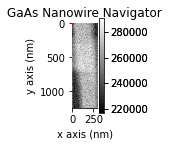

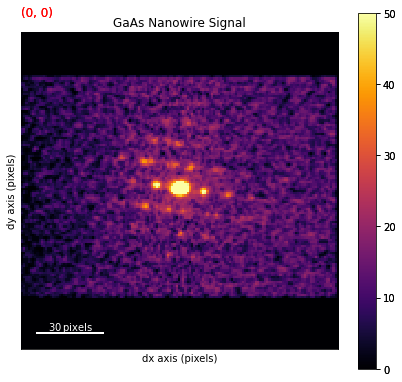

In [17]:
dp.plot(cmap='inferno', vmax=50)

Measure known interplanar spacing to obtain calibration

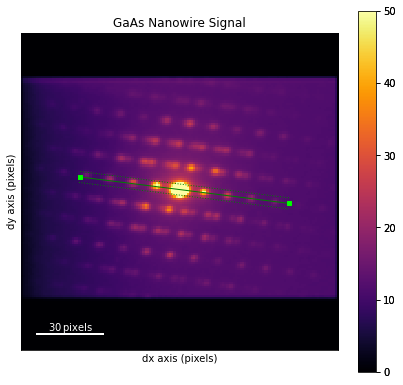

In [18]:
dpm = dp.mean((0,1))
dpm.plot(cmap='inferno', vmax=50)
line = hs.roi.Line2DROI(x1=25.8525, y1=64.5691, x2=120.907, y2=77.0079, linewidth=5.49734)
line.add_widget(dpm)

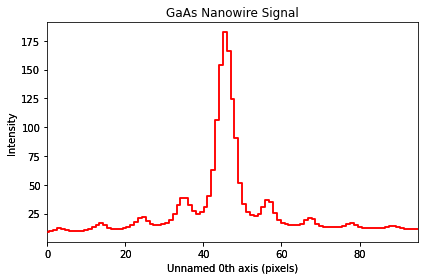

In [19]:
trace = line(dpm)
trace.plot()

In [20]:
recip_d111 = np.sqrt((3/5.6535**2))
recip_cal = recip_d111 / 11.4

Set data calibrations

In [21]:
dp.set_diffraction_calibration(recip_cal)
dp.set_scan_calibration(10)

Plot the calibrated data

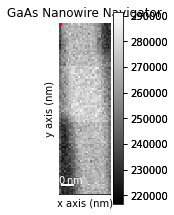

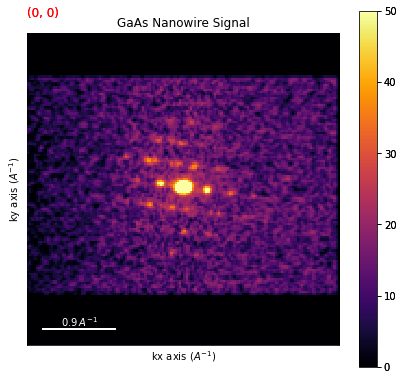

In [22]:
dp.plot(cmap='inferno', vmax=50)

<a id='vdf'></a>

##  3. Virtual Diffraction Imaging & Selecting Regions

### 3.1 Interactive VDF Imaging

Plot an interactive virtual image integrating intensity within a circular subset of pixels in the diffraction pattern

In [23]:
roi = hs.roi.CircleROI(cx=0.,cy=0, r_inner=0, r=0.07)

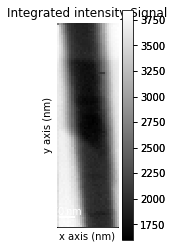

In [24]:
dp.plot_integrated_intensity(roi)

Get the virtual diffraction image associated with the last integration window used interactively

In [25]:
vdf = dp.get_integrated_intensity(roi)

Plot the virtual dark-field image

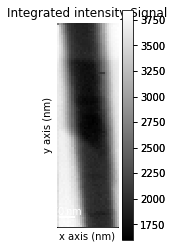

In [26]:
vdf.plot()

Inspect the metadata

In [27]:
vdf.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 21.0
│       │       └── exposure_time = 10.0
│       ├── beam_energy = 300.0
│       ├── camera_length = 0.21000000000000002
│       ├── convergence_angle = 0.7
│       └── scan_rotation = 277.0
├── Diffraction
│   └── integrated_range = CircleROI(cx=0, cy=0, r=0.07) of GaAs Nanowire
├── General
│   ├── original_filename = nanowire_precession.blo
│   ├── time = (2014, 12, 8)
│   └── title = Integrated intensity
└── Signal
    ├── binned = False
    ├── signal_origin = 
    └── signal_type =

Save the virtual dark-field image as a 32bit tif

In [28]:
vdf.change_dtype('float32')
vdf.save('vdfeg.tif')

### 3.2 Form multiple images using a VDF Generator

Import the VirtualImageGenerator class

In [29]:
from pyxem.generators.virtual_image_generator import VirtualImageGenerator

Initialize the VDFGenerator

In [30]:
vdfgen = VirtualImageGenerator(dp)

Calculate 10 annular VDF images between 0 and 1 reciprocal angstroms

In [31]:
vdfs = vdfgen.get_concentric_virtual_images(k_min=0,
                                        k_max=1,
                                        k_steps=10)

Plot the VDF images

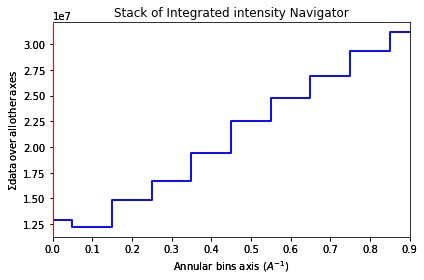

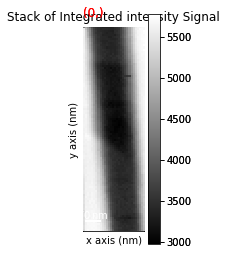

In [32]:
vdfs.plot()

Save the stack of VDF image as a 32bit tif stack

In [33]:
vdfs.change_dtype('float32')
vdfs.save('vdsfeg.tif')

### 3.3 Select a region in the scan

Plot the data with an adjustable marker indicating where to crop the scan region

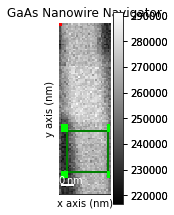

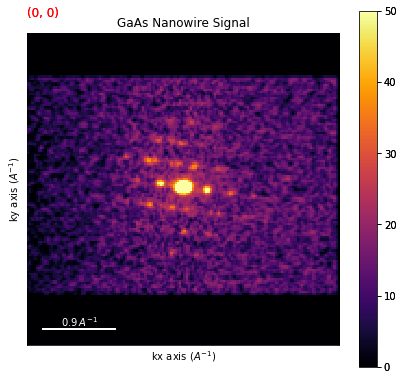

In [34]:
reg = hs.roi.RectangularROI(left=50, top=630, right=290, bottom=870)
dp.plot(cmap='inferno', vmax=50)
reg.add_widget(dp)

Crop the dataset based on the region defined above

In [35]:
dpc = reg(dp)

Calculate the mean diffraction pattern from the selected region

In [36]:
dpcm = dpc.mean((0,1))

Plot the mean diffraction pattern from the selected region

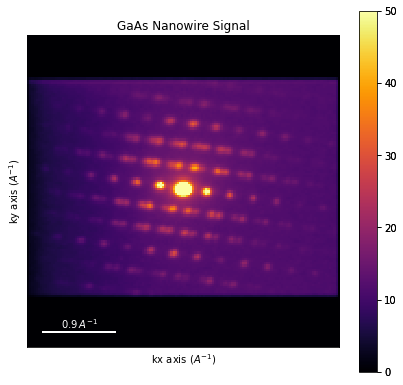

In [37]:
dpcm.plot(cmap='inferno', vmax=50)

<a id='ml'></a>


## 4. Unsupervised learning

Perform singular value decomposition (SVD) of the data

In [38]:
dpc.data = dpc.data.astype('float64')
dpc.decomposition(True, algorithm='SVD')

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


Obtain a "Scree plot" by plotting the fraction of variance described by each principal component

<AxesSubplot:title={'center':'GaAs Nanowire\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

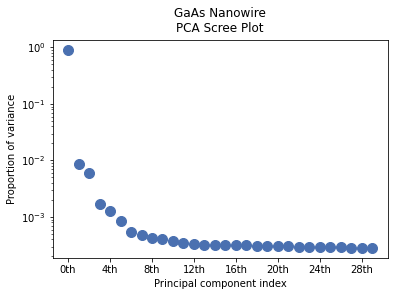

In [39]:
dpc.plot_explained_variance_ratio()

Plot the decomposition results and have a look at them

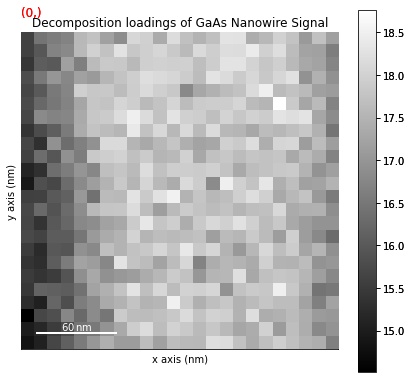

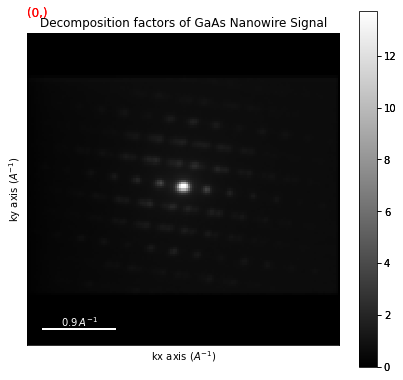

In [40]:
dpc.plot_decomposition_results()

Perform non-negative matrix factorisation (NMF)

In [41]:
dpc.decomposition(True, algorithm='NMF', output_dimension=3)

/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=3
  centre=None
scikit-learn estimator:
NMF(n_components=3)


Plot the NMF results

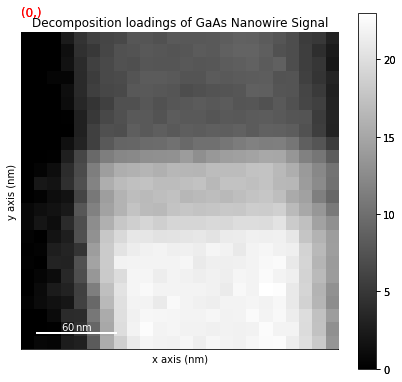

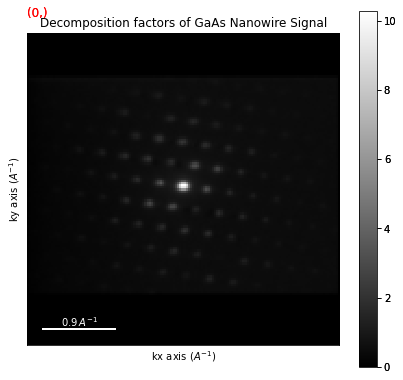

In [42]:
dpc.plot_decomposition_results()

<a id='vec'></a>

##  5. Peak Finding

Perform peak finding on all diffraction patterns in data

In [43]:
peaks = dpc.find_peaks(method='difference_of_gaussian',
                       min_sigma=1.,
                       max_sigma=6.,
                       sigma_ratio=1.6,
                       threshold=0.04,
                       overlap=0.99,
                       interactive=False)

Check the peaks object type

In [44]:
peaks

<BaseSignal, title: GaAs Nanowire, dimensions: (24, 24|)>

Look at what's in the peaks object

In [45]:
print(peaks.inav[0,0].data)
print(" ")
print(peaks.inav[1,1].data)

[[60 58]
 [61 69]
 [71 71]]
 
[[ 60  58]
 [ 70  60]
 [ 61  69]
 [ 71  71]
 [ 82  73]
 [ 73  82]
 [115 132]]


coaxing peaks back into a DiffractionVectors

In [46]:
from pyxem.signals.diffraction_vectors import DiffractionVectors

In [47]:
peaks = DiffractionVectors.from_peaks(peaks,center=(72,72),calibration=recip_cal)

Plot found peak positions as an overlay on the data

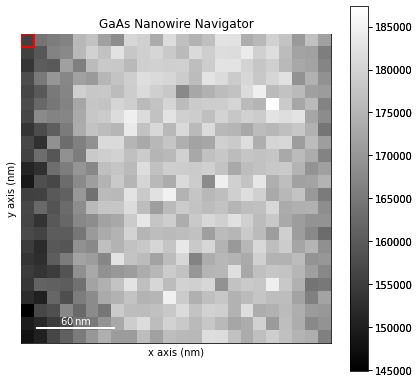

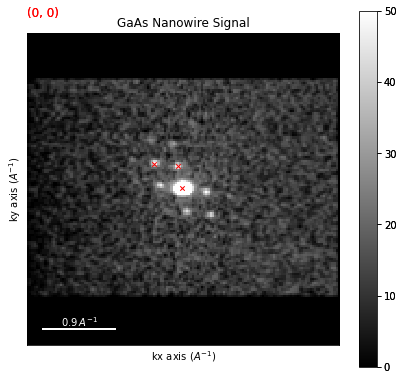

In [48]:
peaks.plot_diffraction_vectors_on_signal(dpc, cmap='gray', vmax=50)

Form a diffracting pixels map to show where peaks were found and plot it

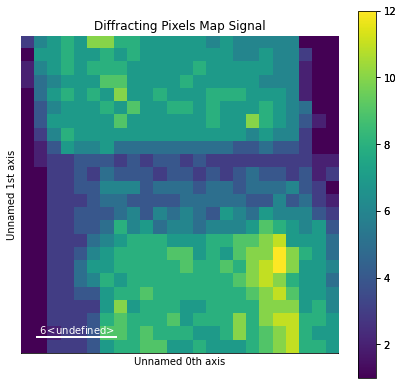

In [49]:
crystim = peaks.get_diffracting_pixels_map(binary=False)
crystim.plot(cmap='viridis')